# Applying Autoencoders to DNA Methylation data from TCGA (MLB Lab) (1000 *23 -> 256 *23 -> 500 -> 100 -> -> 500 -> 256 *23 -> 5000 ->1000 *23)

In [1]:
import joblib
import pandas as pd

meth_df_path =  "pancancer_meth_chr_nonna_fillnamean.pkl"
pancancer_meth_list = joblib.load(meth_df_path)
len(pancancer_meth_list)

23

In [4]:
mv_pancancer_meth_list = []
for df in pancancer_meth_list:
    most_variable_genes = df.mad(axis = 0).nlargest(1000, keep='all').index.values.tolist()
    #Subseting the genes from mvg_v3_df that are on the most_variable_genes list
    mvf_df = df[most_variable_genes]
    mv_pancancer_meth_list.append(mvf_df)
len(mv_pancancer_meth_list)

## Saving the list of chromosome dataframe
joblib.dump(mv_pancancer_meth_list, "pancancer_meth_1000_chr_nonna_fillnamean.pkl")

23

In [7]:
## Saving the list of chromosome dataframe
joblib.dump(mv_pancancer_meth_list, "pancancer_meth_1000_chr_nonna_fillnamean.pkl")

['pancancer_meth_1000_chr_nonna_fillnamean.pkl']

### 2. Building a  Autoencoder

In [8]:
import tensorflow as tf
# print(tf.__version__)
print(tf.config.list_physical_devices())

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [9]:
import numpy as np # linear algebra
import pandas as pd 
import matplotlib.pyplot as plt

import tensorflow as tf
from numpy.random import seed
from sklearn.model_selection import train_test_split
from keras.layers import Input, Dense, Concatenate
from keras.models import Model
from keras import backend as K #For explicitly \adjusting the learning rate
import tensorflow.keras.backend as JC

In [10]:
X_train, X_val = train_test_split(mv_pancancer_meth_list[0], test_size=0.2, random_state = seed(76))
#Since the samples will be split similarly across all chromosomes, we shall match the indices for 
# X_train and X_val across all chr
training_indices = X_train.index
validation_indices = X_val.index

X_train_list = []
X_val_list = []
for chrom_df in mv_pancancer_meth_list:
    X_train_list.append(chrom_df.loc[training_indices])
    X_val_list.append(chrom_df.loc[validation_indices])

In [145]:
ncol_list = []
for df in mv_pancancer_meth_list:
    ncol_list.append(df.shape[1])
    
number_of_chromosomes = len(mv_pancancer_meth_list)

chromsomome_dim = 100 #256*23
hidden_layer_dim_1 = 1024
hidden_layer_dim_2 = 512
encoding_dim = 100 #Nodes in Bottleneck layer

# Encoder Layers
encoded1_list = []
input_dim_list = []
for ncol in ncol_list:
    input_dim_i = Input(shape = (ncol, ))
    input_dim_list.append(input_dim_i)
    encoded1_list.append(Dense(chromsomome_dim, activation = 'relu')(input_dim_i))

encoded1 = Concatenate(axis=1)(encoded1_list)
encoded2 = Dense(hidden_layer_dim_1, activation = 'relu')(encoded1)
encoded3 = Dense(hidden_layer_dim_2, activation = 'relu')(encoded2)
encoded4 = Dense(encoding_dim, activation = 'relu')(encoded3)

# Decoder Layers
decoded4 = Dense(hidden_layer_dim_2, activation = 'relu')(encoded4)
decoded3 = Dense(hidden_layer_dim_1, activation = 'relu')(decoded4)
decoded2 = Dense(chromsomome_dim*number_of_chromosomes, activation = 'relu')(decoded3)

reconstructured_inputs = []
for i in range(0,number_of_chromosomes):
    start = chromsomome_dim*(i)
    end = chromsomome_dim*i+1
    decoded2_i = decoded2[:,start:end] #Splicing the tensor back to chromsomome_dim*23 tensors
    reconstructured_inputs.append(Dense(ncol_list[i], activation = 'sigmoid')(decoded2_i))

In [146]:
def averaged_mean_squared_error(y_true, y_pred):
    return (K.sqrt(K.mean(K.square(y_pred - y_true))))/number_of_chromosomes

# def averaged_binary_crossentropy(y_true, y_pred):
#     bce = tf.keras.losses.BinaryCrossentropy(reduction='sum')
#     return (bce(y_true, y_pred)/number_of_chromosomes

In [147]:
autoencoder = Model(inputs = input_dim_list, outputs = reconstructured_inputs)
# Compile the Model
autoencoder.compile(optimizer = 'adam', loss = averaged_mean_squared_error) 
#adam - stochastic gradient descent algorithm
K.set_value(autoencoder.optimizer.learning_rate, 0.001)
autoencoder.summary()

Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_47 (InputLayer)          [(None, 1001)]       0           []                               
                                                                                                  
 input_48 (InputLayer)          [(None, 1001)]       0           []                               
                                                                                                  
 input_49 (InputLayer)          [(None, 1003)]       0           []                               
                                                                                                  
 input_50 (InputLayer)          [(None, 1000)]       0           []                               
                                                                                           

 dense_119 (Dense)              (None, 100)          100300      ['input_64[0][0]']               
                                                                                                  
 dense_120 (Dense)              (None, 100)          100400      ['input_65[0][0]']               
                                                                                                  
 dense_121 (Dense)              (None, 100)          100900      ['input_66[0][0]']               
                                                                                                  
 dense_122 (Dense)              (None, 100)          100800      ['input_67[0][0]']               
                                                                                                  
 dense_123 (Dense)              (None, 100)          100200      ['input_68[0][0]']               
                                                                                                  
 dense_124

                                                                                                  
 tf.__operators__.getitem_58 (S  (None, 1)           0           ['dense_130[0][0]']              
 licingOpLambda)                                                                                  
                                                                                                  
 tf.__operators__.getitem_59 (S  (None, 1)           0           ['dense_130[0][0]']              
 licingOpLambda)                                                                                  
                                                                                                  
 tf.__operators__.getitem_60 (S  (None, 1)           0           ['dense_130[0][0]']              
 licingOpLambda)                                                                                  
                                                                                                  
 tf.__oper

                                                                 0]']                             
                                                                                                  
 dense_148 (Dense)              (None, 1002)         2004        ['tf.__operators__.getitem_63[0][
                                                                 0]']                             
                                                                                                  
 dense_149 (Dense)              (None, 1003)         2006        ['tf.__operators__.getitem_64[0][
                                                                 0]']                             
                                                                                                  
 dense_150 (Dense)              (None, 1008)         2016        ['tf.__operators__.getitem_65[0][
                                                                 0]']                             
          

In [148]:
# #Implementing Early Stopping
# from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
# import datetime

# # earlystopping_callback = EarlyStopping(monitor='val_loss', patience=4, min_delta=0.0001)

# log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# # import h5py
# # !pip install --upgrade h5py=1.8.21
# # #Saving best Model after the Stopping
# # mc = ModelCheckpoint('meth_ae_v1.h5', monitor='val_loss', mode='min', save_best_only=True, verbose=1)

In [149]:
history = autoencoder.fit(X_train_list, X_train_list, epochs = 50, batch_size = 64, shuffle = False, verbose = 1, validation_data = (X_val_list, X_val_list)) #,callbacks=[tensorboard_callback])

Epoch 1/50
122/122 [==============================] - 12s 62ms/step - loss: 0.2800 - dense_131_loss: 0.0121 - dense_132_loss: 0.0119 - dense_133_loss: 0.0118 - dense_134_loss: 0.0129 - dense_135_loss: 0.0125 - dense_136_loss: 0.0113 - dense_137_loss: 0.0124 - dense_138_loss: 0.0117 - dense_139_loss: 0.0120 - dense_140_loss: 0.0126 - dense_141_loss: 0.0132 - dense_142_loss: 0.0121 - dense_143_loss: 0.0128 - dense_144_loss: 0.0103 - dense_145_loss: 0.0107 - dense_146_loss: 0.0118 - dense_147_loss: 0.0127 - dense_148_loss: 0.0130 - dense_149_loss: 0.0129 - dense_150_loss: 0.0132 - dense_151_loss: 0.0118 - dense_152_loss: 0.0107 - dense_153_loss: 0.0137 - val_loss: 0.2656 - val_dense_131_loss: 0.0113 - val_dense_132_loss: 0.0110 - val_dense_133_loss: 0.0109 - val_dense_134_loss: 0.0127 - val_dense_135_loss: 0.0123 - val_dense_136_loss: 0.0103 - val_dense_137_loss: 0.0122 - val_dense_138_loss: 0.0108 - val_dense_139_loss: 0.0112 - val_dense_140_loss: 0.0123 - val_dense_141_loss: 0.0129 - va

122/122 [==============================] - 5s 44ms/step - loss: 0.2358 - dense_131_loss: 0.0108 - dense_132_loss: 0.0105 - dense_133_loss: 0.0103 - dense_134_loss: 0.0106 - dense_135_loss: 0.0102 - dense_136_loss: 0.0098 - dense_137_loss: 0.0109 - dense_138_loss: 0.0102 - dense_139_loss: 0.0108 - dense_140_loss: 0.0101 - dense_141_loss: 0.0114 - dense_142_loss: 0.0108 - dense_143_loss: 0.0107 - dense_144_loss: 0.0085 - dense_145_loss: 0.0091 - dense_146_loss: 0.0104 - dense_147_loss: 0.0102 - dense_148_loss: 0.0117 - dense_149_loss: 0.0107 - dense_150_loss: 0.0109 - dense_151_loss: 0.0103 - dense_152_loss: 0.0094 - dense_153_loss: 0.0074 - val_loss: 0.2358 - val_dense_131_loss: 0.0108 - val_dense_132_loss: 0.0105 - val_dense_133_loss: 0.0104 - val_dense_134_loss: 0.0106 - val_dense_135_loss: 0.0102 - val_dense_136_loss: 0.0098 - val_dense_137_loss: 0.0109 - val_dense_138_loss: 0.0103 - val_dense_139_loss: 0.0107 - val_dense_140_loss: 0.0102 - val_dense_141_loss: 0.0114 - val_dense_142_

122/122 [==============================] - 5s 44ms/step - loss: 0.2343 - dense_131_loss: 0.0107 - dense_132_loss: 0.0105 - dense_133_loss: 0.0103 - dense_134_loss: 0.0106 - dense_135_loss: 0.0100 - dense_136_loss: 0.0098 - dense_137_loss: 0.0109 - dense_138_loss: 0.0102 - dense_139_loss: 0.0107 - dense_140_loss: 0.0101 - dense_141_loss: 0.0114 - dense_142_loss: 0.0107 - dense_143_loss: 0.0106 - dense_144_loss: 0.0084 - dense_145_loss: 0.0089 - dense_146_loss: 0.0104 - dense_147_loss: 0.0101 - dense_148_loss: 0.0117 - dense_149_loss: 0.0106 - dense_150_loss: 0.0108 - dense_151_loss: 0.0103 - dense_152_loss: 0.0093 - dense_153_loss: 0.0074 - val_loss: 0.2344 - val_dense_131_loss: 0.0107 - val_dense_132_loss: 0.0105 - val_dense_133_loss: 0.0103 - val_dense_134_loss: 0.0105 - val_dense_135_loss: 0.0100 - val_dense_136_loss: 0.0098 - val_dense_137_loss: 0.0109 - val_dense_138_loss: 0.0102 - val_dense_139_loss: 0.0107 - val_dense_140_loss: 0.0101 - val_dense_141_loss: 0.0114 - val_dense_142_

122/122 [==============================] - 5s 44ms/step - loss: 0.2341 - dense_131_loss: 0.0107 - dense_132_loss: 0.0105 - dense_133_loss: 0.0103 - dense_134_loss: 0.0106 - dense_135_loss: 0.0100 - dense_136_loss: 0.0098 - dense_137_loss: 0.0109 - dense_138_loss: 0.0101 - dense_139_loss: 0.0106 - dense_140_loss: 0.0101 - dense_141_loss: 0.0114 - dense_142_loss: 0.0107 - dense_143_loss: 0.0106 - dense_144_loss: 0.0084 - dense_145_loss: 0.0089 - dense_146_loss: 0.0104 - dense_147_loss: 0.0101 - dense_148_loss: 0.0117 - dense_149_loss: 0.0106 - dense_150_loss: 0.0108 - dense_151_loss: 0.0103 - dense_152_loss: 0.0093 - dense_153_loss: 0.0074 - val_loss: 0.2340 - val_dense_131_loss: 0.0107 - val_dense_132_loss: 0.0105 - val_dense_133_loss: 0.0103 - val_dense_134_loss: 0.0105 - val_dense_135_loss: 0.0100 - val_dense_136_loss: 0.0098 - val_dense_137_loss: 0.0109 - val_dense_138_loss: 0.0102 - val_dense_139_loss: 0.0106 - val_dense_140_loss: 0.0099 - val_dense_141_loss: 0.0114 - val_dense_142_

122/122 [==============================] - 6s 45ms/step - loss: 0.2328 - dense_131_loss: 0.0107 - dense_132_loss: 0.0105 - dense_133_loss: 0.0103 - dense_134_loss: 0.0105 - dense_135_loss: 0.0100 - dense_136_loss: 0.0098 - dense_137_loss: 0.0109 - dense_138_loss: 0.0101 - dense_139_loss: 0.0106 - dense_140_loss: 0.0090 - dense_141_loss: 0.0114 - dense_142_loss: 0.0107 - dense_143_loss: 0.0106 - dense_144_loss: 0.0084 - dense_145_loss: 0.0089 - dense_146_loss: 0.0104 - dense_147_loss: 0.0101 - dense_148_loss: 0.0117 - dense_149_loss: 0.0106 - dense_150_loss: 0.0108 - dense_151_loss: 0.0103 - dense_152_loss: 0.0093 - dense_153_loss: 0.0074 - val_loss: 0.2331 - val_dense_131_loss: 0.0107 - val_dense_132_loss: 0.0105 - val_dense_133_loss: 0.0103 - val_dense_134_loss: 0.0105 - val_dense_135_loss: 0.0100 - val_dense_136_loss: 0.0098 - val_dense_137_loss: 0.0109 - val_dense_138_loss: 0.0102 - val_dense_139_loss: 0.0106 - val_dense_140_loss: 0.0090 - val_dense_141_loss: 0.0114 - val_dense_142_

In [143]:
len(history.history['loss'])

50

dict_keys(['loss', 'dense_79_loss', 'dense_80_loss', 'dense_81_loss', 'dense_82_loss', 'dense_83_loss', 'dense_84_loss', 'dense_85_loss', 'dense_86_loss', 'dense_87_loss', 'dense_88_loss', 'dense_89_loss', 'dense_90_loss', 'dense_91_loss', 'dense_92_loss', 'dense_93_loss', 'dense_94_loss', 'dense_95_loss', 'dense_96_loss', 'dense_97_loss', 'dense_98_loss', 'dense_99_loss', 'dense_100_loss', 'dense_101_loss', 'val_loss', 'val_dense_79_loss', 'val_dense_80_loss', 'val_dense_81_loss', 'val_dense_82_loss', 'val_dense_83_loss', 'val_dense_84_loss', 'val_dense_85_loss', 'val_dense_86_loss', 'val_dense_87_loss', 'val_dense_88_loss', 'val_dense_89_loss', 'val_dense_90_loss', 'val_dense_91_loss', 'val_dense_92_loss', 'val_dense_93_loss', 'val_dense_94_loss', 'val_dense_95_loss', 'val_dense_96_loss', 'val_dense_97_loss', 'val_dense_98_loss', 'val_dense_99_loss', 'val_dense_100_loss', 'val_dense_101_loss'])


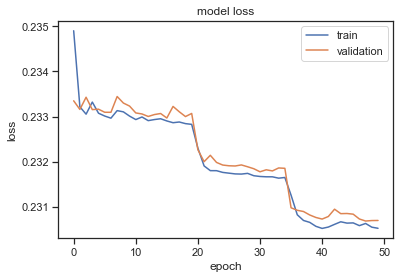

In [144]:
#Visualizing the Loss over epochs
print(history.history.keys())
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [87]:
%load_ext tensorboard
%tensorboard --logdir logs/fit

In [127]:
#Obtain the reduced data
encoder = Model(inputs = input_dim_list, outputs = encoded4)
# encoded_input = Input(shape = (encoding_dim, ))

encoded_train = pd.DataFrame(encoder.predict(mv_pancancer_meth_list), index=mv_pancancer_meth_list[0].index) #Maintain Index for Mapping to cancer type 
encoded_train = encoded_train.add_prefix('feature_')
encoded_train.shape

(9756, 100)

In [128]:
#output dataset
shape_before_removing_nan = encoded_train.shape
encoded_train.replace(0, np.nan, inplace=True) #Converting all the zero's to nan to use nan command
encoded_train.dropna(how='all',axis=1, inplace=True) #Removing columns with all nan rows
encoded_train.dropna(how='all',axis=0, inplace=True) #Removing rows with all nan columns
encoded_train.replace(np.nan, 0, inplace=True) #Converting all the nan's to zero to be compatible with t-SNE
print(shape_before_removing_nan, encoded_train.shape)

# encoded_train.to_csv("Meth_AE_v2.csv", index=True)
# encoded_train = pd.read_csv("Meth_AE_v2.csv",index_col=[0,1,2,3,4])

(9756, 100) (9756, 77)


In [129]:
#Scaling these features to -1,1 range for applying tsne
from sklearn.preprocessing import MinMaxScaler
feature_list = encoded_train.columns.tolist()
scaler = MinMaxScaler(feature_range=(0,1))
encoded_train[feature_list] = scaler.fit_transform(encoded_train[feature_list])

In [130]:
# encoded_train = pd.read_csv("Meth_AE_v2.csv",index_col=[0,1,2,3,4])

In [131]:
encoded_train.head()

,,,,,feature_1,feature_2,feature_3,feature_4,feature_5,feature_7,feature_10,feature_11,feature_13,feature_14,...,feature_87,feature_89,feature_90,feature_91,feature_93,feature_94,feature_95,feature_96,feature_97,feature_99
patient,sample,sample_type,aliquot,file,,,,,,,,,,,,,,,,,,,,,
TCGA-OR-A5J4,TCGA-OR-A5J4-01A,01A,TCGA-OR-A5J4-01A-11D-A29J-05,Y:\qiu-lab\Bridget\data\meth\methylation_raw\adrenocortical\0874f4b8-5743-4b41-9b99-f02186c8b51e\jhu-usc.edu_ACC.HumanMethylation450.1.lvl-3.TCGA-OR-A5J4-01A-11D-A29J-05.gdc_hg38_betaonly.txt,0.00000,0.066074,0.163116,0.0,0.269769,0.606387,0.201090,0.373695,0.320737,0.447225,...,0.000000,0.0,0.313298,0.396175,0.000000,0.037890,0.372974,0.230948,0.0,0.025301
TCGA-OR-A5KO,TCGA-OR-A5KO-01A,01A,TCGA-OR-A5KO-01A-11D-A29J-05,Y:\qiu-lab\Bridget\data\meth\methylation_raw\adrenocortical\0885b557-48ca-4865-b17a-f2e1f6209b81\jhu-usc.edu_ACC.HumanMethylation450.1.lvl-3.TCGA-OR-A5KO-01A-11D-A29J-05.gdc_hg38_betaonly.txt,0.00000,0.191731,0.084862,0.0,0.320114,0.331748,0.314367,0.581559,0.113365,0.372211,...,0.210915,0.0,0.551195,0.737366,0.000000,0.000000,0.050976,0.199408,0.0,0.000000
TCGA-OR-A5J9,TCGA-OR-A5J9-01A,01A,TCGA-OR-A5J9-01A-11D-A29J-05,Y:\qiu-lab\Bridget\data\meth\methylation_raw\adrenocortical\09eb5b05-2794-437b-a307-5255f69c4a32\jhu-usc.edu_ACC.HumanMethylation450.1.lvl-3.TCGA-OR-A5J9-01A-11D-A29J-05.gdc_hg38_betaonly.txt,0.00000,0.577796,0.000000,0.0,0.765526,0.000820,0.133288,0.323548,0.199361,0.399519,...,0.185559,0.0,0.738927,0.811584,0.000000,0.012672,0.167211,0.185027,0.0,0.055288
TCGA-OR-A5K6,TCGA-OR-A5K6-01A,01A,TCGA-OR-A5K6-01A-11D-A29J-05,Y:\qiu-lab\Bridget\data\meth\methylation_raw\adrenocortical\10ee4988-4a8f-4a0e-ae63-cc891c765fba\jhu-usc.edu_ACC.HumanMethylation450.1.lvl-3.TCGA-OR-A5K6-01A-11D-A29J-05.gdc_hg38_betaonly.txt,0.00000,0.186800,0.218320,0.0,0.537832,0.213043,0.179738,0.590995,0.338070,0.412514,...,0.129183,0.0,0.668049,0.730692,0.000000,0.067872,0.071228,0.553204,0.0,0.000000
TCGA-OR-A5JJ,TCGA-OR-A5JJ-01A,01A,TCGA-OR-A5JJ-01A-11D-A29J-05,Y:\qiu-lab\Bridget\data\meth\methylation_raw\adrenocortical\16ff6c63-eca7-4376-a13e-682682b74e11\jhu-usc.edu_ACC.HumanMethylation450.1.lvl-3.TCGA-OR-A5JJ-01A-11D-A29J-05.gdc_hg38_betaonly.txt,0.07824,0.387653,0.029593,0.0,0.738015,0.047369,0.039299,0.578406,0.000000,0.156062,...,0.485608,0.0,0.501382,0.562424,0.307131,0.000000,0.000000,0.397003,0.0,0.000000


### 6. Dimension Reduction and Cluster Visualization using t-SNE 


perplexity parameter can be changed based on the input datatset - dataset with larger number of variables requires larger perplexity set this value between 5 and 50 (sklearn documentation) verbose=1 displays run time messages set n_iter sufficiently high to resolve the well stabilized cluster get embeddings


In [132]:
# Perform t-SNE on AE encoded_features
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, init='pca', random_state=0, perplexity=40, learning_rate=300, n_iter=400, verbose=1)
#TSNE(n_components=2, perplexity=105, n_iter=1000, verbose=1).fit_transform(encoded_train)
tsne_out = tsne.fit_transform(encoded_train)
tsne_components = pd.DataFrame(tsne_out, index =encoded_train.index ) #Maintain Index


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 9756 samples in 0.001s...
[t-SNE] Computed neighbors for 9756 samples in 2.404s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9756
[t-SNE] Computed conditional probabilities for sample 2000 / 9756
[t-SNE] Computed conditional probabilities for sample 3000 / 9756
[t-SNE] Computed conditional probabilities for sample 4000 / 9756
[t-SNE] Computed conditional probabilities for sample 5000 / 9756
[t-SNE] Computed conditional probabilities for sample 6000 / 9756
[t-SNE] Computed conditional probabilities for sample 7000 / 9756
[t-SNE] Computed conditional probabilities for sample 8000 / 9756
[t-SNE] Computed conditional probabilities for sample 9000 / 9756
[t-SNE] Computed conditional probabilities for sample 9756 / 9756
[t-SNE] Mean sigma: 0.299615


C:\Users\ssrikrishnan6\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 78.172241
[t-SNE] KL divergence after 400 iterations: 1.843958


In [133]:
tsne_components = pd.DataFrame(tsne_out, index =encoded_train.index ) #Maintain Index
tsne_components.head()

,,,,,0,1
patient,sample,sample_type,aliquot,file,,
TCGA-OR-A5J4,TCGA-OR-A5J4-01A,01A,TCGA-OR-A5J4-01A-11D-A29J-05,Y:\qiu-lab\Bridget\data\meth\methylation_raw\adrenocortical\0874f4b8-5743-4b41-9b99-f02186c8b51e\jhu-usc.edu_ACC.HumanMethylation450.1.lvl-3.TCGA-OR-A5J4-01A-11D-A29J-05.gdc_hg38_betaonly.txt,-12.824086,11.307063
TCGA-OR-A5KO,TCGA-OR-A5KO-01A,01A,TCGA-OR-A5KO-01A-11D-A29J-05,Y:\qiu-lab\Bridget\data\meth\methylation_raw\adrenocortical\0885b557-48ca-4865-b17a-f2e1f6209b81\jhu-usc.edu_ACC.HumanMethylation450.1.lvl-3.TCGA-OR-A5KO-01A-11D-A29J-05.gdc_hg38_betaonly.txt,4.615498,12.731408
TCGA-OR-A5J9,TCGA-OR-A5J9-01A,01A,TCGA-OR-A5J9-01A-11D-A29J-05,Y:\qiu-lab\Bridget\data\meth\methylation_raw\adrenocortical\09eb5b05-2794-437b-a307-5255f69c4a32\jhu-usc.edu_ACC.HumanMethylation450.1.lvl-3.TCGA-OR-A5J9-01A-11D-A29J-05.gdc_hg38_betaonly.txt,5.880197,14.285216
TCGA-OR-A5K6,TCGA-OR-A5K6-01A,01A,TCGA-OR-A5K6-01A-11D-A29J-05,Y:\qiu-lab\Bridget\data\meth\methylation_raw\adrenocortical\10ee4988-4a8f-4a0e-ae63-cc891c765fba\jhu-usc.edu_ACC.HumanMethylation450.1.lvl-3.TCGA-OR-A5K6-01A-11D-A29J-05.gdc_hg38_betaonly.txt,6.146911,11.952713
TCGA-OR-A5JJ,TCGA-OR-A5JJ-01A,01A,TCGA-OR-A5JJ-01A-11D-A29J-05,Y:\qiu-lab\Bridget\data\meth\methylation_raw\adrenocortical\16ff6c63-eca7-4376-a13e-682682b74e11\jhu-usc.edu_ACC.HumanMethylation450.1.lvl-3.TCGA-OR-A5JJ-01A-11D-A29J-05.gdc_hg38_betaonly.txt,15.252970,-8.809084


### 7. Mapping samples to cancer type


In [134]:
import pandas as pd
patient_metadata = pd.read_csv(r"C:\Users\ssrikrishnan6\ae_integration\info_all_ex.txt", sep = "\t")
patient_metadata = patient_metadata[[ 'cases.0.samples.0.portions.0.analytes.0.aliquots.0.submitter_id','cases.0.project.project_id','cases.0.samples.0.sample_type']] #tolist()
patient_metadata.rename(columns={'cases.0.project.project_id': "cancer_type", "cases.0.samples.0.portions.0.analytes.0.aliquots.0.submitter_id":"tcga_id"},inplace=True)
patient_metadata.set_index("tcga_id", inplace=True)

new_patient_indices = []
for index in patient_metadata.index:
    new_patient_indices.append("-".join(index.split("-")[:-3]))
patient_metadata.index = new_patient_indices

In [135]:
patient_metadata.head()

,cancer_type,cases.0.samples.0.sample_type
TCGA-NC-A5HI-01A,TCGA-LUSC,Primary Tumor
TCGA-68-8251-01A,TCGA-LUSC,Primary Tumor
TCGA-98-A53A-01A,TCGA-LUSC,Primary Tumor
TCGA-39-5029-01A,TCGA-LUSC,Primary Tumor
TCGA-22-5474-01A,TCGA-LUSC,Primary Tumor


In [136]:
new_indices = []
for index in tsne_components.index:
    new_index = index[1]
    new_indices.append(new_index)
tsne_components.index = new_indices

# new_tsne_components = tsne_components.copy()
# new_tsne_components.index = new_indices

# #Merging based on tcga_id
grouped_tsne = pd.merge(tsne_components , patient_metadata['cancer_type'] , left_index=True, right_index=True)

print(grouped_tsne.shape)
grouped_tsne.head()

(9151, 3)


,0,1,cancer_type
TCGA-05-4384-01A,1.667883,-18.487396,TCGA-LUAD
TCGA-05-4390-01A,-21.326506,8.862639,TCGA-LUAD
TCGA-05-4396-01A,-17.269512,-9.707122,TCGA-LUAD
TCGA-05-4405-01A,-17.048120,15.276240,TCGA-LUAD
TCGA-05-4410-01A,-5.414731,-8.814618,TCGA-LUAD


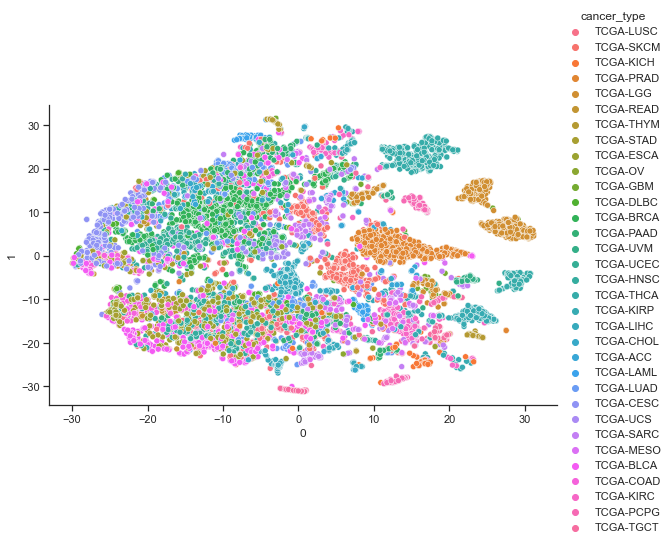

In [137]:
import matplotlib.pyplot as plt
import seaborn
seaborn.set(style='ticks')

cancer_types = grouped_tsne['cancer_type'].tolist()
cancer_types = list(set(cancer_types))

seaborn.relplot(data=grouped_tsne, x=0, y=1, hue='cancer_type', hue_order=cancer_types, aspect=1.61)
plt.show()

Relplot = A figure-level function for visualizing statistical relationships using two common approaches: scatter plots and line plots. relplot() combines a FacetGrid with one of two axes-level functions: scatterplot() (with kind="scatter" ; the default)

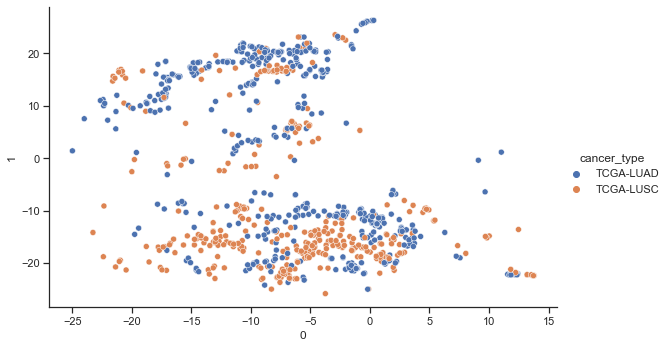

In [138]:
lung_cancer_types = ["TCGA-LUAD","TCGA-LUSC"] 
lung_cancer_df = grouped_tsne[grouped_tsne['cancer_type'].isin(lung_cancer_types)]

seaborn.relplot(data=lung_cancer_df, x=0, y=1, hue='cancer_type', hue_order=lung_cancer_types, aspect=1.61)
plt.show()

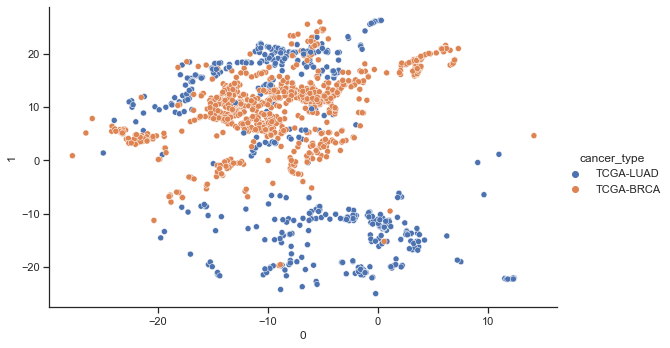

In [139]:
lung_breast_cancer_types = ["TCGA-LUAD","TCGA-BRCA"] 
lung_breast_cancer_df = grouped_tsne[grouped_tsne['cancer_type'].isin(lung_breast_cancer_types)]

seaborn.relplot(data=lung_breast_cancer_df, x=0, y=1, hue='cancer_type', hue_order=lung_breast_cancer_types, aspect=1.61)
plt.show()

In [4]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [3]:
import os
print (os.environ['CONDA_DEFAULT_ENV'])

tf_gpu


In [8]:
def plot_latent(z, anno, save = None, figsize = (10,10), axis_label = "Latent", **kwargs):
    _kwargs = {
        "s": 10,
        "alpha": 0.9,
    }
    _kwargs.update(kwargs)

    fig = plt.figure(figsize = figsize)
    ax = fig.add_subplot()
    cluster_types = set([x for x in np.unique(anno)])
    colormap = plt.cm.get_cmap("tab20", len(cluster_types))

    for i, cluster_type in enumerate(cluster_types):
        index = np.where(anno == cluster_type)[0]
        ax.scatter(z[index,0], z[index,1], color = colormap(i), label = cluster_type, **_kwargs)
    
    ax.legend(loc='upper left', prop={'size': 15}, frameon = False, ncol = 1, bbox_to_anchor=(1.04, 1))
    
    ax.tick_params(axis = "both", which = "major", labelsize = 15)

    ax.set_xlabel(axis_label + " 1", fontsize = 19)
    ax.set_ylabel(axis_label + " 2", fontsize = 19)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)  
    
    if save:
        fig.savefig(save, bbox_inches = "tight")
    
    print(save)


# plot_latent(ae_coordinates, anno_ctrl, axis_label = "Latent", save = "AE.pdf")

In [7]:
 !pip3 show tensorflow

Name: tensorflow
Version: 2.8.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: c:\users\ssrikrishnan6\anaconda3\lib\site-packages
Requires: libclang, six, h5py, keras-preprocessing, termcolor, google-pasta, opt-einsum, tensorboard, gast, astunparse, flatbuffers, tf-estimator-nightly, tensorflow-io-gcs-filesystem, grpcio, protobuf, typing-extensions, absl-py, setuptools, wrapt, numpy, keras
Required-by: 


In [ ]:
import tf-night